Within the In[1] I'm simply importing the packages that will be used during this drill. Worth noting, this drill uses Tensorflow on the backend, and as of the publish date of this kernel you will need to use Python 3.5 for tensorflow to work properly. 

In [1]:
# Imports & Froms and others 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import adam
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
%matplotlib inline
np.random.seed(5)


Using TensorFlow backend.


During this section we are prepairing the data for the model, and in doing so we are checking the CSV files manually, and also taking steps to "clean the data" via code. Also, the path provided below is directly linked to the Kaggle directory, and not the directory on your PC. 

In [2]:
#Loading the Number Recognition files provided by Kaggle. 

train =pd.read_csv("../input/train.csv")
test =pd.read_csv("../input/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Cleaning up space, and the files that were just uploaded, and validating them via value counts

In [3]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Checking for null values, or missing data in cells 

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Here we are normalizing the data for our CNN model via gray scale normalization 

In [6]:
X_train = X_train / 255.0
test = test / 255.0

Reshaping the images from 1D to 3D and we use te 1 channel in Keras due to the images being in grey scale. Below you see that it was switched to 28x28x1 

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Setting labels at 10 which == 0-9

In [8]:
Y_train = to_categorical(Y_train, num_classes = 10)

Here we start to get into the actual split testing, and training within the model

In [9]:
random_seed = 5
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

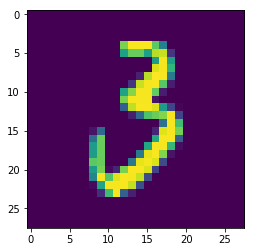

In [10]:
# Showing an example of our training 
g = plt.imshow(X_train[5][:,:,0])

CNN using SWISH activation f(x)=x*sigmoid(x) 
reference: https://medium.com/@jaiyamsharma/experiments-with-swish-activation-function-on-mnist-dataset-fc89a8c79ff7

In [11]:
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

In [12]:
#CNN Arcitecture with afromentioned "Swish Activation from Google"

model = Sequential()
get_custom_objects().update({'swish': Activation(swish )})
model.add(Conv2D(filters = 42, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish', input_shape = (28,28,1)))
model.add(Conv2D(filters = 42, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.50))
model.add(Conv2D(filters = 84, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(Conv2D(filters = 84, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(5,5), strides=(5,5)))
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(256, activation = "swish"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "sigmoid"))

Here we optomize the model based on known values ( results ) and we match what our CNN was able to generate with vs. the known values.

For Learning rate, we have set it to decrease every epoch after the 3rd by 0.5 if there is nothing improved as it pertains to accuracy. 

Furthermore, the model was trained on 37800 samples and validated on 4200 samples with 2 epochs with a 200 batch size the following results :

Train on 37800 samples, validate on 4200 samples
Epoch 1/2
 - 191s - loss: 0.6541 - acc: 0.8007 - val_loss: 0.1375 - val_acc: 0.9643
Epoch 2/2
 - 187s - loss: 0.2521 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.9750
 
 
For an epoch of 5 with a 50 batch size:
 
 Train on 37800 samples, validate on 4200 samples
Epoch 1/5
 - 11s - loss: 0.6306 - acc: 0.7909 - val_loss: 0.0945 - val_acc: 0.9724
Epoch 2/5
 - 6s - loss: 0.1907 - acc: 0.9465 - val_loss: 0.0638 - val_acc: 0.9802
Epoch 3/5
 - 6s - loss: 0.1515 - acc: 0.9572 - val_loss: 0.0509 - val_acc: 0.9862
Epoch 4/5
 - 6s - loss: 0.1241 - acc: 0.9644 - val_loss: 0.0485 - val_acc: 0.9874
Epoch 5/5
 - 6s - loss: 0.1124 - acc: 0.9699 - val_loss: 0.0492 - val_acc: 0.9876
 

In [13]:
optimizer= adam(lr=0.001,epsilon=1e-08,decay=0.0)
model.compile(optimizer =optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30 
batch_size = 50
history_da = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)



Train on 37800 samples, validate on 4200 samples
Epoch 1/30
 - 10s - loss: 0.6297 - acc: 0.7926 - val_loss: 0.0899 - val_acc: 0.9731
Epoch 2/30
 - 5s - loss: 0.1927 - acc: 0.9457 - val_loss: 0.0585 - val_acc: 0.9833
Epoch 3/30
 - 5s - loss: 0.1501 - acc: 0.9584 - val_loss: 0.0539 - val_acc: 0.9857
Epoch 4/30
 - 5s - loss: 0.1280 - acc: 0.9642 - val_loss: 0.0483 - val_acc: 0.9871
Epoch 5/30
 - 5s - loss: 0.1133 - acc: 0.9688 - val_loss: 0.0460 - val_acc: 0.9874
Epoch 6/30
 - 5s - loss: 0.1002 - acc: 0.9721 - val_loss: 0.0426 - val_acc: 0.9879
Epoch 7/30
 - 5s - loss: 0.0999 - acc: 0.9724 - val_loss: 0.0405 - val_acc: 0.9890
Epoch 8/30
 - 5s - loss: 0.0896 - acc: 0.9741 - val_loss: 0.0518 - val_acc: 0.9888
Epoch 9/30
 - 5s - loss: 0.0876 - acc: 0.9761 - val_loss: 0.0431 - val_acc: 0.9907
Epoch 10/30
 - 5s - loss: 0.0879 - acc: 0.9757 - val_loss: 0.0391 - val_acc: 0.9886
Epoch 11/30
 - 5s - loss: 0.0810 - acc: 0.9777 - val_loss: 0.0317 - val_acc: 0.9905
Epoch 12/30
 - 5s - loss: 0.0785 - 

We evaluated the model using a few graphs as shown below 

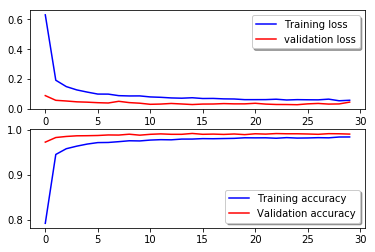

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history_da.history['loss'], color='b', label="Training loss")
ax[0].plot(history_da.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history_da.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_da.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Here we finalize our process by predicting the results 

In [15]:
# Results
results = model.predict(test)
# Picking the ones with highest probability 
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

Now we upload our results to a file for submission using Pandas 

In [16]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("sub_Darawsheh.csv",index=False)